# **Musculoskeletal Radiographs Abnormality Detection**

# **Exploratory Data Analysis**

### **Problem**

Determining whether a radiographic study is normal or abnormal is a critical radiological task: a study interpreted as normal rules out disease and can eliminate the need for patients to undergo further diagnostic procedures or interventions. The musculoskeletal abnormality detection task is particularly critical as more than 1.7 billion people are affected by musculoskeletal conditions worldwide (BMU, 2017). These conditions are the most common cause of severe, long-term pain and disability (Woolf & Pfleger, 2003), with 30 million emergency department visits annually and increasing. Our dataset, MURA, contains 9,045 normal and 5,818 abnormal musculoskeletal radiographic studies of the upper extremity including the shoulder, humerus, elbow, forearm, wrist, hand, and finger. MURA is one of the largest public radiographic image datasets. More information about the  the dataset can be found [here](http://stanfordmlgroup.github.io/competitions/mura/)  as well as [in this paper](http://https://arxiv.org/pdf/1712.06957.pdf)

# Libraries

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load data

This data comes as split dataset (training & validation in separate directories). Each data categories such as training & validation has sub-directories (pls see below).


```

└─train {data category}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data category}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
                        └───...
```

## First we Download the dataset

In [3]:
"""
%%bash
wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'
unzip MURA-v1.1.zip
"""

"\n%%bash\nwget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'\nunzip MURA-v1.1.zip\n"

#### Let us load the Dataset

In [4]:
cd ../input/mura-v11

/kaggle/input/mura-v11


##### Helper Function for loading dataset

In [5]:
def load_path(path):
    dataset = []
    for body in os.listdir(path):
        body_part = body

        path_p = path+'/'+str(body)

        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0

                path_l = path_id+'/'+str(lab)

                for img in os.listdir(path_l):
                    img_path = path_l + '/' + str(img)
    
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [6]:
path = 'MURA-v1.1/train'
os.listdir(path)

['XR_WRIST',
 'XR_FINGER',
 'XR_SHOULDER',
 'XR_HAND',
 'XR_FOREARM',
 'XR_HUMERUS',
 'XR_ELBOW']

In [7]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head(2)

,body_part,patient_id,label,img_path
0,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study1_n...
1,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study1_n...


In [8]:
dataset_test = load_path(path = 'MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)

## Data Preprocessing

#### Creating Dataset for the Model traing and generating Labels for the same.

In [9]:
df_train['label_index']= df_train.label
df_train.label_index.replace('positive', 1, inplace=True)
df_train.label_index.replace('negative', 0, inplace=True)
df_train.head(3)

,body_part,patient_id,label,img_path,label_index
0,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study1_n...,0
1,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study1_n...,0
2,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study1_n...,0


In [10]:
df_test['label_index']= df_test.label
df_test.label_index.replace('positive', 1, inplace=True)
df_test.label_index.replace('negative', 0, inplace=True)

## Exploratory Data Analysis

In [11]:
print('We have '+str(len(df_train))+' train images from all body parts')

We have 36812 train images from all body parts


In [12]:
print("Total Number of training images : ", len(df_train["img_path"]))

Total Number of training images :  36812


In [13]:
print ("\n\nnumber of null values in:\n", df_train.isnull().sum())



number of null values in:
 body_part      0
patient_id     0
label          0
img_path       0
label_index    0
dtype: int64


In [14]:
categories_counts = pd.DataFrame(df_train['body_part'].value_counts())
print ('\n\ncategories:\n',categories_counts )



categories:
              body_part
XR_WRIST          9756
XR_SHOULDER       8379
XR_HAND           5543
XR_FINGER         5106
XR_ELBOW          4931
XR_FOREARM        1825
XR_HUMERUS        1272


In [15]:
print('\n\nnumber of patients:',df_train['patient_id'].nunique())



number of patients: 11184


In [16]:
print('\n\nNumber of different labels:',df_train['label'].nunique())



Number of different labels: 2


#### Different Catagories of Body in which we are checking for abnormality

In [17]:
print('We have Bone X-Ray from: ')
path = 'MURA-v1.1/train'
print(*os.listdir(path), sep = "\n")

We have Bone X-Ray from: 
XR_WRIST
XR_FINGER
XR_SHOULDER
XR_HAND
XR_FOREARM
XR_HUMERUS
XR_ELBOW


##### Helper Function for Visualization of Dataset

In [18]:
def count_distrib(df_body, body_name):
    grouped = df_body.groupby(df_body.label)
    pos = len(grouped.get_group(1))
    print('We have ' +str(pos)+ ' positive with abnormality '+ body_name + ' scans')
    neg = len(grouped.get_group(0))
    print( 'We have ' +str(neg)+ ' negative with abnormality '+ body_name + ' scans')
    total = len(df_body)
    return body_name, pos, neg, total

#### Exploring Different Catagories of Body in which we are checking for abnormality

### 1. Elbow Joint

In [19]:
grouped = df_train.groupby(df_train.body_part)
df_XR_ELBOW = grouped.get_group("XR_ELBOW")
df_XR_ELBOW.head(4)

,body_part,patient_id,label,img_path,label_index
31881,XR_ELBOW,patient05626,0,MURA-v1.1/train/XR_ELBOW/patient05626/study1_n...,0
31882,XR_ELBOW,patient05626,0,MURA-v1.1/train/XR_ELBOW/patient05626/study1_n...,0
31883,XR_ELBOW,patient06133,0,MURA-v1.1/train/XR_ELBOW/patient06133/study1_n...,0
31884,XR_ELBOW,patient06133,0,MURA-v1.1/train/XR_ELBOW/patient06133/study1_n...,0


In [20]:
print("Number of training Examples for ELBOW Joint : ",len(df_XR_ELBOW))

Number of training Examples for ELBOW Joint :  4931


In [21]:
training_data_distr = []

In [22]:
body_name, pos, neg, total = count_distrib(df_XR_ELBOW, 'XR_ELBOW')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 2006 positive with abnormality XR_ELBOW scans
We have 2925 negative with abnormality XR_ELBOW scans


### 2. Finger Joint

In [23]:
df_XR_FINGER = grouped.get_group("XR_FINGER")


In [24]:
print("Number of training XR_FINGER: ",len(df_XR_FINGER))

Number of training XR_FINGER:  5106


In [25]:
body_name, pos, neg, total = count_distrib(df_XR_FINGER, 'XR_FINGER')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 1968 positive with abnormality XR_FINGER scans
We have 3138 negative with abnormality XR_FINGER scans


### 3. Forearm Joint

In [26]:
df_XR_FOREARM = grouped.get_group("XR_FOREARM")

In [27]:
print("Number of training XR_FOREARM: ",len(df_XR_FOREARM))

Number of training XR_FOREARM:  1825


In [28]:
body_name, pos, neg, total = count_distrib(df_XR_FOREARM, 'XR_FOREARM')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 661 positive with abnormality XR_FOREARM scans
We have 1164 negative with abnormality XR_FOREARM scans


### 4. Hand Joint

In [29]:
df_XR_HAND = grouped.get_group("XR_HAND")

In [30]:
print("Number of training XR_HAND: ",len(df_XR_HAND))

Number of training XR_HAND:  5543


In [31]:
body_name, pos, neg, total = count_distrib(df_XR_HAND, 'XR_HAND')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 1484 positive with abnormality XR_HAND scans
We have 4059 negative with abnormality XR_HAND scans


### 5. Humerus Joint

In [32]:
df_XR_HUMERUS = grouped.get_group("XR_HUMERUS")

In [33]:
print("Number of training XR_HUMERUS: ",len(df_XR_HUMERUS))

Number of training XR_HUMERUS:  1272


In [34]:
body_name, pos, neg, total = count_distrib(df_XR_HUMERUS, 'XR_HUMERUS')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 599 positive with abnormality XR_HUMERUS scans
We have 673 negative with abnormality XR_HUMERUS scans


### 6. Shoulder Joint

In [35]:
df_XR_SHOULDER = grouped.get_group("XR_SHOULDER")

In [36]:
print("Number of training XR_SHOULDER: ",len(df_XR_SHOULDER))

Number of training XR_SHOULDER:  8379


In [37]:
body_name, pos, neg, total = count_distrib(df_XR_SHOULDER, 'XR_SHOULDER')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 4168 positive with abnormality XR_SHOULDER scans
We have 4211 negative with abnormality XR_SHOULDER scans


### 7. Wrist Joint

In [38]:
df_XR_WRIST = grouped.get_group("XR_WRIST")

In [39]:
print("Number of training XR_WRIST: ",len(df_XR_WRIST))

Number of training XR_WRIST:  9756


In [40]:
body_name, pos, neg, total = count_distrib(df_XR_WRIST, 'XR_WRIST')

training_data_distr.append(
                    {
                    'body_part': body_name,
                    'positive': pos,
                    'negative': neg,
                    'total':total
                    })

We have 3987 positive with abnormality XR_WRIST scans
We have 5769 negative with abnormality XR_WRIST scans


### Explore data distribution with plots

In [41]:
training_data_distr = pd.DataFrame(training_data_distr)

In [42]:
training_data_distr['percentage'] = round(100 * training_data_distr['total'] / len(df_train.body_part), 2)

#### The Overview of our Training Dataset

In [43]:
print('Training Data Distribution')
training_data_distr

Training Data Distribution


,body_part,positive,negative,total,percentage
0,XR_ELBOW,2006,2925,4931,13.40
1,XR_FINGER,1968,3138,5106,13.87
2,XR_FOREARM,661,1164,1825,4.96
3,XR_HAND,1484,4059,5543,15.06
4,XR_HUMERUS,599,673,1272,3.46
5,XR_SHOULDER,4168,4211,8379,22.76
6,XR_WRIST,3987,5769,9756,26.50


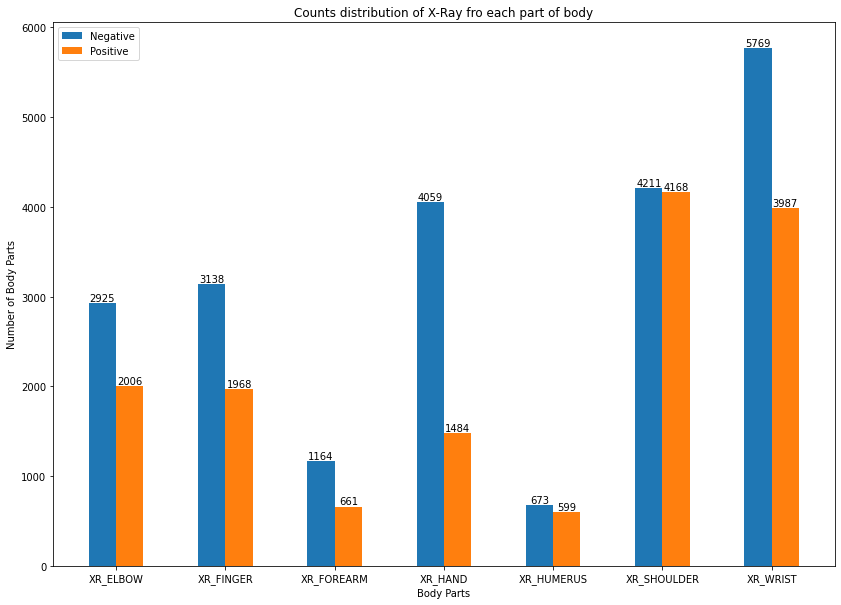

In [44]:
labels = training_data_distr['body_part']
negative = training_data_distr['negative']
positive = training_data_distr['positive']

x = np.arange(len(labels))
width = 0.25

fig = plt.figure(figsize=(14, 10))

ax = fig.subplots()
rects1 = ax.bar(x - width/2, negative, width, label='Negative')
rects2 = ax.bar(x + width/2, positive, width, label='Positive')
ax.set_ylabel('Number of Body Parts')
ax.set_xlabel('Body Parts')
ax.set_title('Counts distribution of X-Ray fro each part of body')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

### Observation from the graph is -
* We have the least data for Humerus Joint followed by Forearm.
* We have the largest data for Wrist and Shoulder.
* This variation in the data point will make it more harder for the model to learn about Abnormality in Humerus and Forearm joint.


### Let us analyze dataset more

##### 1. Training Set

In [45]:
grouped = df_train.groupby(df_train.label)
pos = len(grouped.get_group(1))
neg = len(grouped.get_group(0))

In [46]:
print("Number of positives:",pos)
print("Number of negatives:",neg)

Number of positives: 14873
Number of negatives: 21939


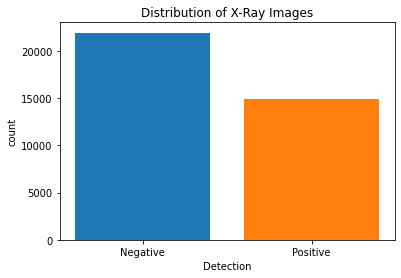

In [47]:
# the data you want to plot
categories = ["Negative"]
values     = [ neg]

categories2 = ["Positive"]
values2     = [  pos]

plt.bar(categories, values)
plt.bar(categories2, values2)
plt.title('Distribution of X-Ray Images')
plt.xlabel('Detection')
plt.ylabel('count')


plt.show()

#### We can conclude that the dataset of trainnig data is unbalance with more negative images.

#### 2. Test set

In [48]:
df_test.label.head()

0    1
1    1
2    1
3    0
4    0
Name: label, dtype: int64

In [49]:
grouped = df_train.groupby(df_train.label)
pos = len(grouped.get_group(1))
neg = len(grouped.get_group(0))

In [50]:
print("Number of positives:",pos)
print("Number of negatives:",neg)

Number of positives: 14873
Number of negatives: 21939


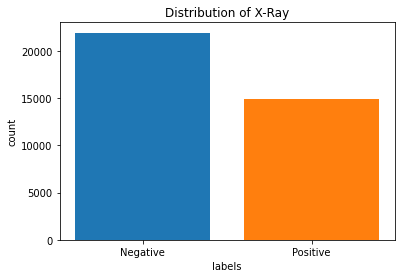

In [51]:
categories = ["Negative"]
values     = [ neg]
categories2 = ["Positive"]
values2     = [  pos]
plt.bar(categories, values)
plt.bar(categories2, values2)
plt.title('Distribution of X-Ray')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

#### The dataset of test data is far more balance than train data.


## Now Preprocessing some Images .

In [52]:
im_size = 256

#### Random Rotation flip

In [53]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [54]:
def image_loader(Path, size = 224):
    
    Images = []
    
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        
        except Exception as e:
            print(str(e))
            
    Images = np.asarray(Images).astype('float32')

    #normalization
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std
    
    return Images

In [55]:
df_train.head()

,body_part,patient_id,label,img_path,label_index
0,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study1_n...,0
1,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study1_n...,0
2,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study1_n...,0
3,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study2_n...,0
4,XR_WRIST,patient07547,0,MURA-v1.1/train/XR_WRIST/patient07547/study2_n...,0


In [56]:
cd ../input/mura-v11

[Errno 2] No such file or directory: '../input/mura-v11'
/kaggle/input/mura-v11


In [57]:
X_train = image_loader(df_train['img_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 58.72it/s]


In [58]:
y_train = df_train['label']
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

In [59]:
X_test = image_loader(df_test['img_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 70.43it/s]


In [60]:
y_test = df_test['label']
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

### Plots/ Visualization of Images.

In [61]:
def print_img_with_colorbar(image):   
    fig = plt.figure()
    plt.imshow(image, cmap = plt.cm.binary)
    plt.colorbar()

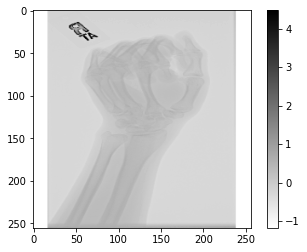

In [62]:
print_img_with_colorbar(X_train[0])

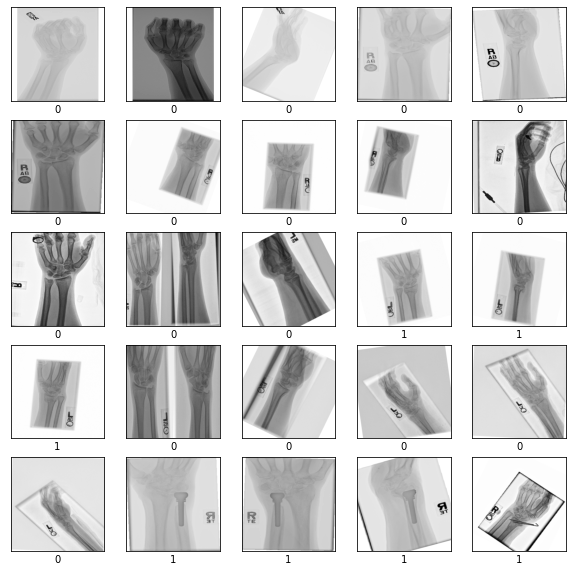

In [63]:
def print_range_images(images, images_label):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(images_label[i])

print_range_images(X_train, y_train)

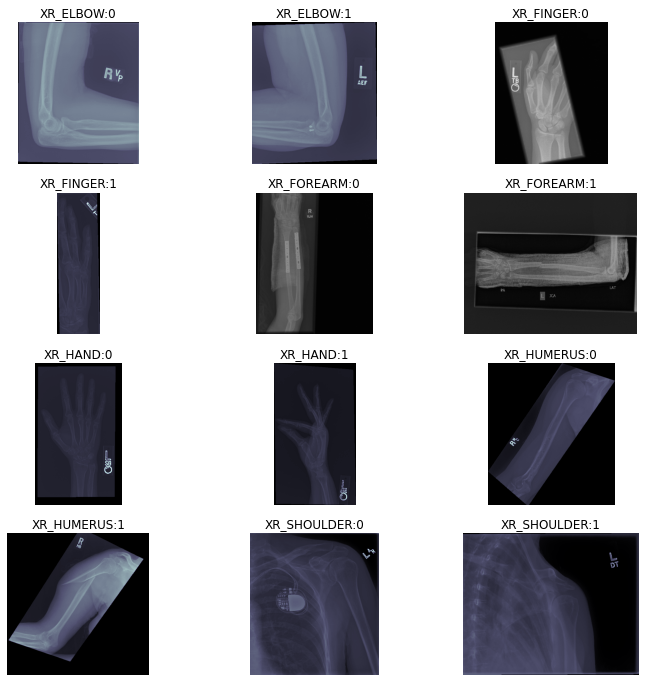

In [64]:
from skimage.io import imread
sub_df = df_train.groupby(['body_part', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['img_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{body_part}:{label}'.format(**c_row))